In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

fees= pd.read_csv('/kaggle/input/trabajo-anthony-ral-y-lvaro/extract - fees - data analyst - .csv')
cr= pd.read_csv('/kaggle/input/trabajo-anthony-ral-y-lvaro/extract - cash request - data analyst.csv')
cr.info()
fees.info()

# Filtrar columnas relevantes para el análisis
cr = cr[["amount", "created_at", "user_id", "deleted_account_id","transfer_type"]]
cr.info()
# Rellenar valores nulos en 'user_id' usando 'deleted_account_id' (clientes␣transferidos de cuentas eliminadas)
cr.fillna({"user_id": cr["deleted_account_id"]}, inplace=True)
# Eliminar la columna 'deleted_account_id' ya que no es necesaria después de la imputación
cr.drop(columns=["deleted_account_id"], inplace=True)
cr.info()
# Convertir 'created_at' a tipo datetime para manipulación de fechas
cr['created_at'] = pd.to_datetime(cr['created_at'])
cr.head()
# Convertir la columna 'created_at' a una fecha sin zona horaria
cr['created_at'] = cr['created_at'].dt.tz_localize(None)
cr.head()
# Crear columna 'Mes' indicando el mes de cada solicitud
cr['Mes'] = cr['created_at'].dt.to_period('M')
cr.head()
# Crear columna 'Cohorte' que indica el mes de la primera solicitud de cada␣cliente
cr['Cohorte'] = cr.groupby('user_id')['created_at'].transform('min').dt.to_period('M')
cr.head(10)
# Calcular el número inicial de clientes únicos en cada cohorte
cohort_sizes_initial = cr.groupby('Cohorte').agg(Num_Clientes_Iniciales=('user_id', 'nunique')).reset_index()

/kaggle/input/trabajo-anthony-ral-y-lvaro/extract - fees - data analyst - .csv
/kaggle/input/trabajo-anthony-ral-y-lvaro/extract - cash request - data analyst.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          23970 non-null  int64  
 1   amount                      23970 non-null  float64
 2   status                      23970 non-null  object 
 3   created_at                  23970 non-null  object 
 4   updated_at                  23970 non-null  object 
 5   user_id                     21867 non-null  float64
 6   moderated_at                16035 non-null  object 
 7   deleted_account_id          2104 non-null   float64
 8   reimbursement_date          23970 non-null  object 
 9   cash_request_received_date  16289 non-null  object 
 10  money_back_date             16543 non-n

In [2]:
# Calcular la cantidad de clientes únicos en cada cohorte para cada mes
cohort_sizes_monthly = cr.groupby(['Cohorte', 'Mes']).agg(Num_Clientes=('user_id', 'nunique')).reset_index()
cohort_sizes_monthly

# Calcular la cantidad de solicitudes de adelanto de efectivo de los clientes␣de cada cohorte en cada mes
cohort_cash_monthly = cr.groupby(['Cohorte', 'Mes']).agg(Num_Solicitudes=('user_id', 'count')).reset_index()
cohort_cash_monthly

# Calcular la tasa de retención de clientes (clientes únicos por cohorte en␣cada mes / clientes iniciales de la cohorte)
retention_clientes = cohort_sizes_monthly.pivot(index='Cohorte', columns='Mes',values='Num_Clientes')
retention_clientes = retention_clientes.div(cohort_sizes_initial.set_index('Cohorte')['Num_Clientes_Iniciales'], axis=0)
retention_clientes


Mes,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11
Cohorte,,,,,,,,,,,,,
2019-11,1.0,1.0,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,1.000000,1.000000,NaN
2019-12,NaN,1.0,0.354331,0.228346,0.267717,0.263780,0.295276,0.287402,0.232283,0.263780,0.169291,0.244094,0.003937
2020-01,NaN,NaN,1.000000,0.207547,0.150943,0.254717,0.254717,0.254717,0.264151,0.198113,0.188679,0.226415,0.009434
2020-02,NaN,NaN,NaN,1.000000,0.500000,0.466667,0.466667,0.433333,0.433333,0.400000,0.277778,0.377778,NaN
2020-03,NaN,NaN,NaN,NaN,1.000000,0.441860,0.430233,0.523256,0.418605,0.395349,0.337209,0.313953,0.011628
2020-04,NaN,NaN,NaN,NaN,NaN,1.000000,0.471545,0.495935,0.373984,0.325203,0.308943,0.247967,NaN
2020-05,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.590278,0.506944,0.430556,0.340278,0.356481,0.009259
2020-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.490909,0.482468,0.372727,0.367532,0.003247
2020-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.474359,0.344804,0.359649,0.004723


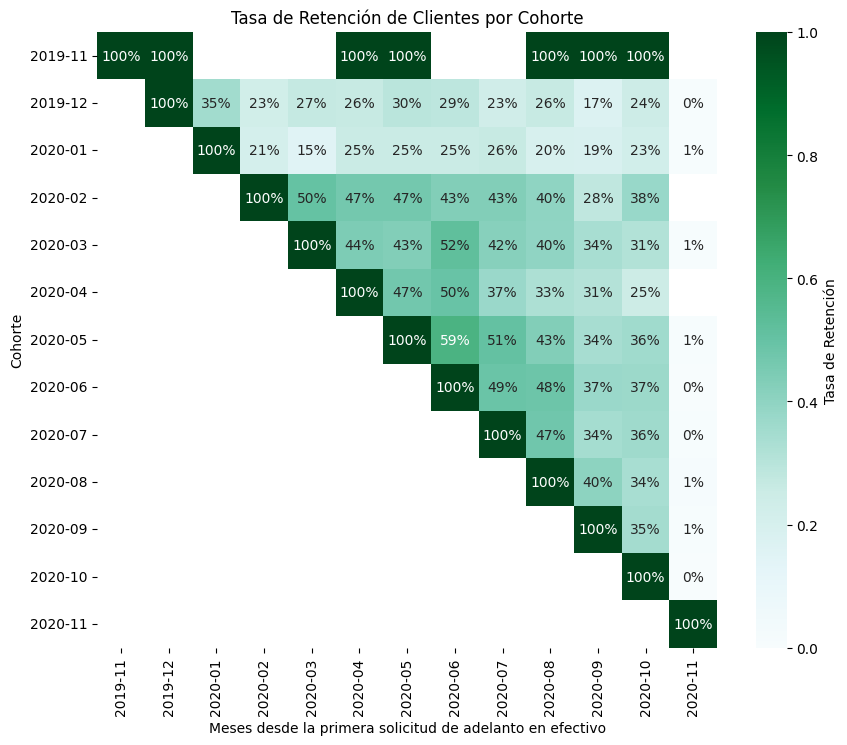

In [3]:
# Visualizar la tasa de retención de clientes usando un mapa de calor
plt.figure(figsize=(10, 8))
plt.title('Tasa de Retención de Clientes por Cohorte')
sns.heatmap(data=retention_clientes, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,cmap='BuGn', cbar_kws={'label': 'Tasa de Retención'})
plt.xlabel('Meses desde la primera solicitud de adelanto en efectivo')
plt.ylabel('Cohorte')
plt.show()


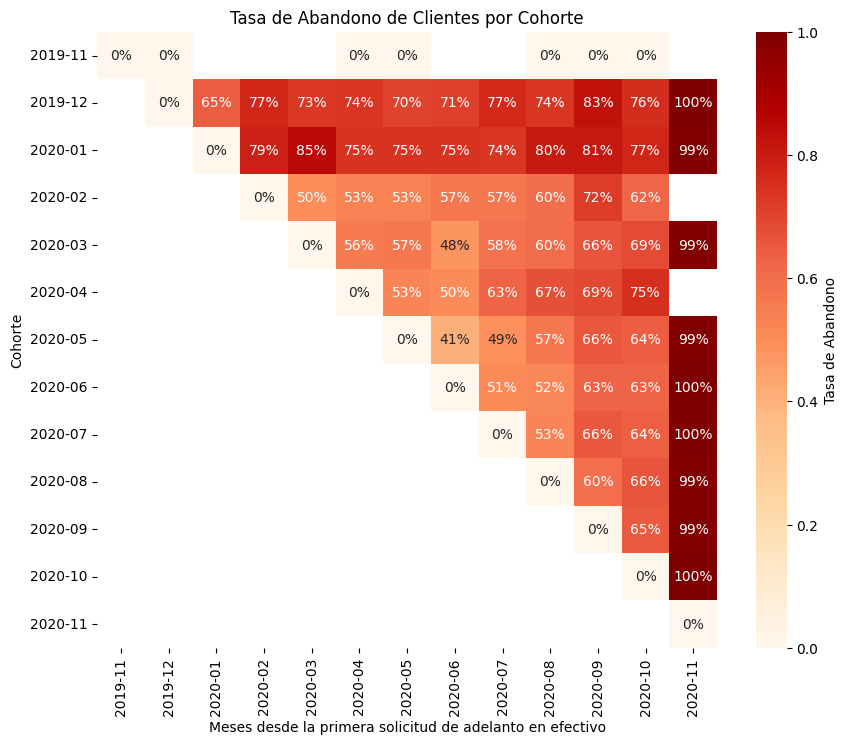

In [4]:
# Calcular la tasa de abandono de clientes (1 - tasa de retención)
churn_clientes = 1 - retention_clientes
# Visualizar la tasa de abandono de clientes usando un mapa de calor
plt.figure(figsize=(10, 8))
plt.title('Tasa de Abandono de Clientes por Cohorte')
sns.heatmap(data=churn_clientes, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,cmap='OrRd', cbar_kws={'label': 'Tasa de Abandono'})
plt.xlabel('Meses desde la primera solicitud de adelanto en efectivo')
plt.ylabel('Cohorte')
plt.show()

In [5]:
# Calcular el número inicial de solicitudes de adelanto de efectivo en cada␣cohorte
cohort_cash_initial = cohort_cash_monthly.groupby('Cohorte').first().reset_index().rename(columns={'Num_Solicitudes':'Num_Solicitudes_Iniciales'})
cohort_cash_initial
# Calcular la tasa de retención de solicitudes (solicitudes por cohorte en cadames / solicitudes iniciales de la cohorte)
retention_cash = cohort_cash_monthly.pivot(index='Cohorte', columns='Mes',values='Num_Solicitudes')
retention_cash = retention_cash.div(cohort_cash_initial.set_index('Cohorte')['Num_Solicitudes_Iniciales'], axis=0)
retention_cash

Mes,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11
Cohorte,,,,,,,,,,,,,
2019-11,1.0,1.0,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,1.000000,2.000000,NaN
2019-12,NaN,1.0,0.368056,0.218750,0.274306,0.284722,0.298611,0.315972,0.250000,0.291667,0.184028,0.260417,0.003472
2020-01,NaN,NaN,1.000000,0.205128,0.145299,0.299145,0.264957,0.247863,0.264957,0.188034,0.188034,0.213675,0.008547
2020-02,NaN,NaN,NaN,1.000000,0.505155,0.505155,0.463918,0.463918,0.463918,0.453608,0.278351,0.412371,NaN
2020-03,NaN,NaN,NaN,NaN,1.000000,0.424242,0.464646,0.474747,0.404040,0.363636,0.303030,0.303030,0.010101
2020-04,NaN,NaN,NaN,NaN,NaN,1.000000,0.568182,0.571970,0.439394,0.405303,0.337121,0.284091,NaN
2020-05,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.665272,0.573222,0.485356,0.376569,0.364017,0.008368
2020-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.531024,0.494829,0.355222,0.339193,0.002585
2020-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.471443,0.304609,0.298096,0.003507


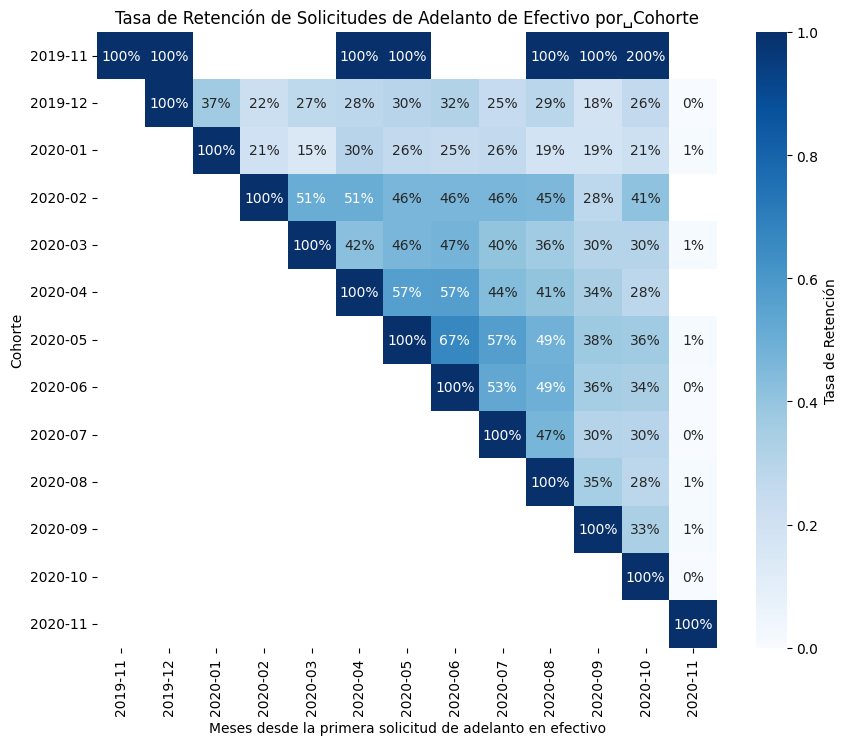

In [6]:
# Visualizar la tasa de retención de solicitudes usando un mapa de calor
plt.figure(figsize=(10, 8))
plt.title('Tasa de Retención de Solicitudes de Adelanto de Efectivo por␣Cohorte')
sns.heatmap(data=retention_cash, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,cmap='Blues', cbar_kws={'label': 'Tasa de Retención'})
plt.xlabel('Meses desde la primera solicitud de adelanto en efectivo')
plt.ylabel('Cohorte')
plt.show()

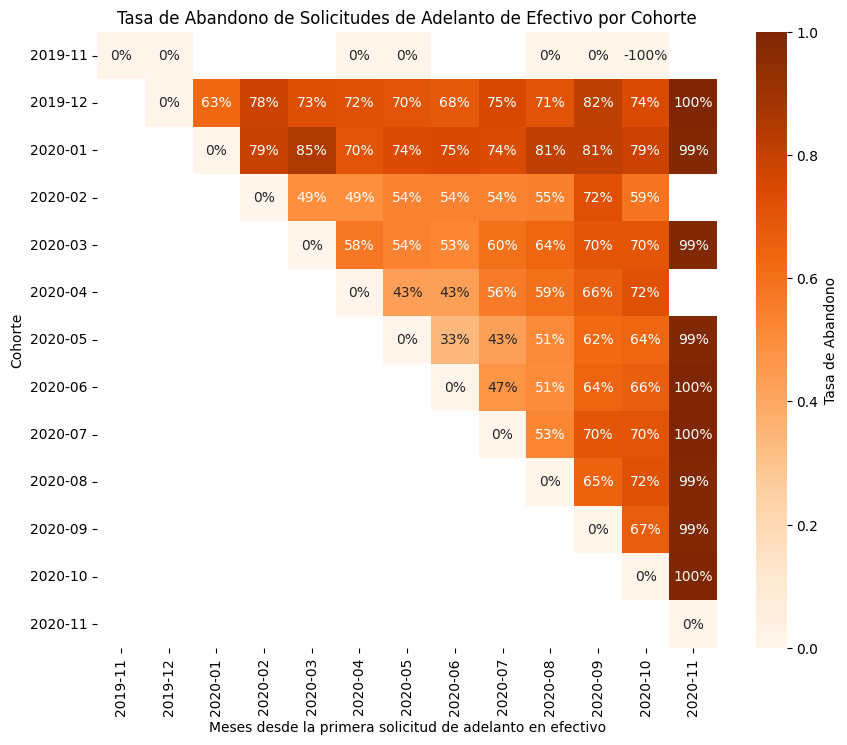

In [7]:
# Calcular la tasa de abandono de solicitudes (1 - tasa de retención de␣solicitudes)
churn_cash = 1 - retention_cash
churn_cash
# Visualizar la tasa de abandono de solicitudes usando un mapa de calor
plt.figure(figsize=(10, 8))
plt.title('Tasa de Abandono de Solicitudes de Adelanto de Efectivo por Cohorte')
sns.heatmap(data=churn_cash, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,cmap='Oranges', cbar_kws={'label': 'Tasa de Abandono'})
plt.xlabel('Meses desde la primera solicitud de adelanto en efectivo')
plt.ylabel('Cohorte')
plt.show()

In [8]:
#FEES

# Inspeccionar la estructura y el tipo de datos de 'fees'
fees.info()
# Crear una copia del DataFrame para preservar el original
fs = fees.copy()
# Filtrar columnas relevantes para el análisis
fs = fs[["cash_request_id", "total_amount", "created_at"]]
fs.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21061 entries, 0 to 21060
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               21061 non-null  int64  
 1   cash_request_id  21057 non-null  float64
 2   type             21061 non-null  object 
 3   status           21061 non-null  object 
 4   category         2196 non-null   object 
 5   total_amount     21061 non-null  float64
 6   reason           21061 non-null  object 
 7   created_at       21061 non-null  object 
 8   updated_at       21061 non-null  object 
 9   paid_at          15531 non-null  object 
 10  from_date        7766 non-null   object 
 11  to_date          7766 non-null   object 
 12  charge_moment    21061 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 2.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21061 entries, 0 to 21060
Data columns (total 3 columns):
 #   Column           Non-Null

In [9]:
# Convertir la columna 'created_at' en fees a tipo datetime para análisis␣temporal
fs['created_at'] = pd.to_datetime(fs['created_at'])
fs.head()
# Convertir la columna 'created_at' a una fecha sin zona horaria
fs['created_at'] = fs['created_at'].dt.tz_localize(None)
fs.head()
# Crear columna 'Mes' indicando el mes de cada solicitud
fs['Mes'] = fs['created_at'].dt.to_period('M')
fs.head()
# Crear columna 'Cohorte' que indica el mes del primer cargo de cada cliente
fs['Cohorte'] = fs.groupby('cash_request_id')['created_at'].transform('min').dt.to_period('M')
fs.head()
# Calcular la cantidad de tarifas iniciales por cohorte
cohort_fees_initial = fs.groupby('Cohorte').agg(Num_Tarifas_Iniciales=('cash_request_id', 'nunique')).reset_index()
cohort_fees_initial


,Cohorte,Num_Tarifas_Iniciales
0,2020-05,14
1,2020-06,447
2,2020-07,856
3,2020-08,1922
4,2020-09,2640
5,2020-10,6930
6,2020-11,124


In [10]:
# Calcular el número de tarifas en cada cohorte para cada mes
cohort_fees_monthly = fs.groupby(['Cohorte', 'Mes']).agg(Num_Tarifas=('cash_request_id', 'nunique')).reset_index()
cohort_fees_monthly

,Cohorte,Mes,Num_Tarifas
0,2020-05,2020-05,14
1,2020-05,2020-06,5
2,2020-05,2020-07,2
3,2020-05,2020-08,1
4,2020-05,2020-09,1
5,2020-05,2020-10,1
6,2020-06,2020-06,447
7,2020-06,2020-07,196
8,2020-06,2020-08,74
9,2020-06,2020-09,42


In [11]:
# Calcular la tasa de retención de tarifas (número de tarifas de cada cohorte␣en cada mes / tarifas iniciales de la cohorte)
retention_fees = cohort_fees_monthly.pivot(index='Cohorte', columns='Mes',values='Num_Tarifas')
retention_fees = retention_fees.div(cohort_fees_initial.set_index('Cohorte')['Num_Tarifas_Iniciales'], axis=0)
retention_fees


Mes,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11
Cohorte,,,,,,,
2020-05,1.0,0.357143,0.142857,0.071429,0.071429,0.071429,NaN
2020-06,NaN,1.000000,0.438479,0.165548,0.093960,0.082774,NaN
2020-07,NaN,NaN,1.000000,0.371495,0.200935,0.143692,NaN
2020-08,NaN,NaN,NaN,1.000000,0.356400,0.197190,NaN
2020-09,NaN,NaN,NaN,NaN,1.000000,0.360985,0.006439
2020-10,NaN,NaN,NaN,NaN,NaN,1.000000,0.014286
2020-11,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


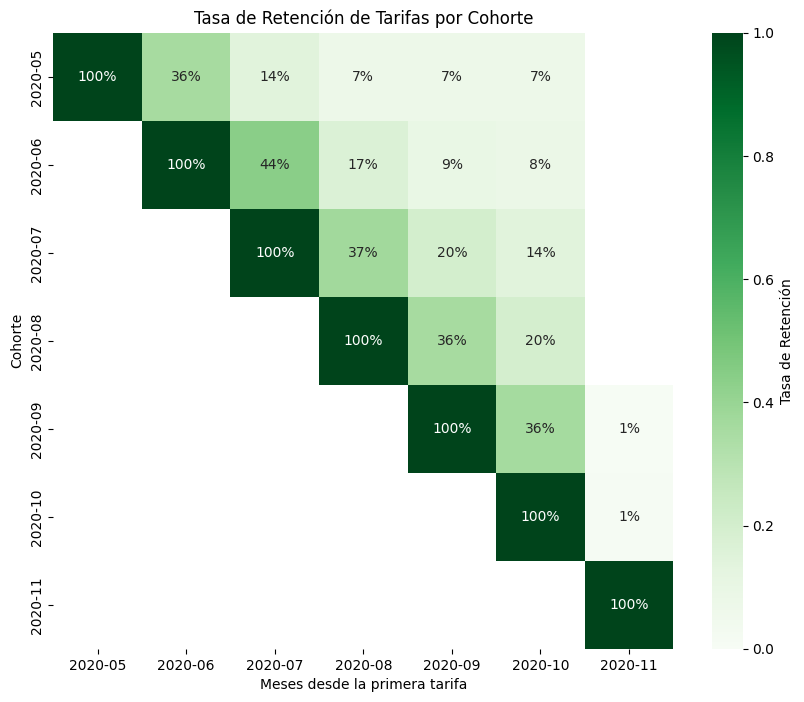

In [12]:
# Visualizar la tasa de retención de tarifas usando un mapa de calor
plt.figure(figsize=(10, 8))
plt.title('Tasa de Retención de Tarifas por Cohorte')
sns.heatmap(data=retention_fees, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,cmap='Greens', cbar_kws={'label': 'Tasa de Retención'})
plt.xlabel('Meses desde la primera tarifa')
plt.ylabel('Cohorte')
plt.show()

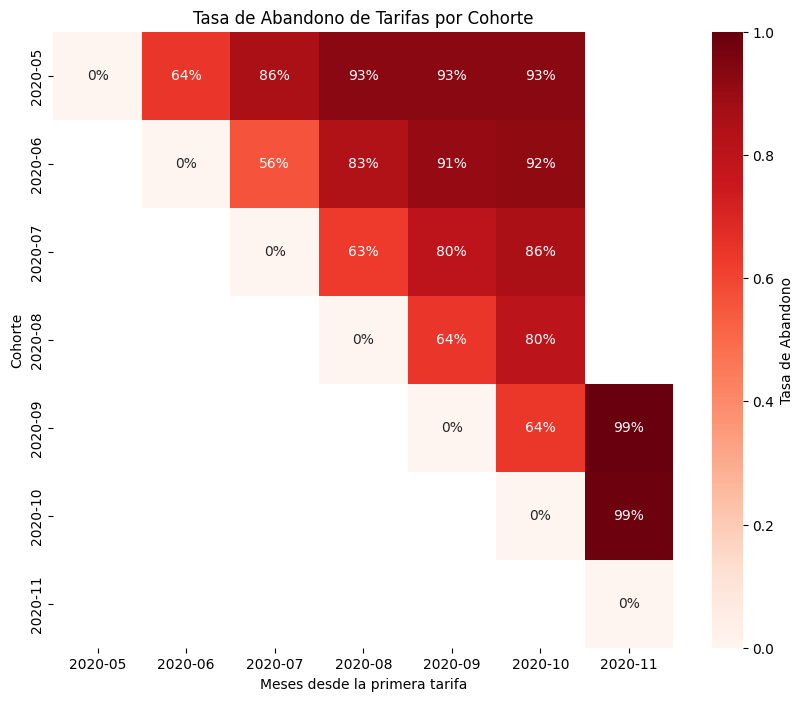

In [13]:
# Calcular la tasa de abandono de tarifas (1 - tasa de retención de tarifas)
churn_fees = 1 - retention_fees
# Visualizar la tasa de abandono de tarifas usando un mapa de calor
plt.figure(figsize=(10, 8))
plt.title('Tasa de Abandono de Tarifas por Cohorte')
sns.heatmap(data=churn_fees, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,cmap='Reds', cbar_kws={'label': 'Tasa de Abandono'})
plt.xlabel('Meses desde la primera tarifa')
plt.ylabel('Cohorte')
plt.show()

In [14]:
# Agregar columnas de temporalidad
# Semana y mes de la solicitud
cr['Semana_Mes'] = cr['created_at'].dt.strftime('%U_%B') + '_' + cr['Mes'].dt.strftime('%Y')
# Día y semana de la solicitud
cr['Dia_Semana'] = cr['created_at'].dt.strftime('%A') + '_' + cr['Semana_Mes']
# Hora y dia de la solicitud
cr['Hora_Dia'] = cr['created_at'].dt.hour.astype(str) + '_' + cr['Dia_Semana']
cr.head()

,amount,created_at,user_id,transfer_type,Mes,Cohorte,Semana_Mes,Dia_Semana,Hora_Dia
0,100.0,2019-12-10 19:05:21.596873,804.0,regular,2019-12,2019-12,49_December_2019,Tuesday_49_December_2019,19_Tuesday_49_December_2019
1,100.0,2019-12-10 19:50:12.347780,231.0,regular,2019-12,2019-12,49_December_2019,Tuesday_49_December_2019,19_Tuesday_49_December_2019
2,100.0,2019-12-10 19:13:35.825460,191.0,regular,2019-12,2019-12,49_December_2019,Tuesday_49_December_2019,19_Tuesday_49_December_2019
3,99.0,2019-12-10 19:16:10.880172,761.0,regular,2019-12,2019-12,49_December_2019,Tuesday_49_December_2019,19_Tuesday_49_December_2019
4,100.0,2020-05-06 09:59:38.877376,7686.0,regular,2020-05,2020-05,18_May_2020,Wednesday_18_May_2020,9_Wednesday_18_May_2020


In [15]:
# Calcular la cantidad de adelanto de efectivo por cohorte y mes
cohort_revenue = cr.groupby(['Cohorte', 'Mes'])['amount'].sum().reset_index()
cohort_revenue = cohort_revenue.pivot(index='Cohorte', columns='Mes',values='amount')
cohort_revenue


Mes,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11
Cohorte,,,,,,,,,,,,,
2019-11,1.0,100.0,NaN,NaN,NaN,100.0,10.0,NaN,NaN,10.0,5.0,6.0,NaN
2019-12,NaN,27197.0,10123.0,5881.0,7650.0,7900.0,8175.0,8805.0,6990.0,7790.0,4860.0,6655.0,100.0
2020-01,NaN,NaN,11464.0,2360.0,1660.0,3500.0,3020.0,2770.0,3010.0,2150.0,1970.0,2350.0,100.0
2020-02,NaN,NaN,NaN,8412.0,4740.0,4607.0,4350.0,4235.0,4405.0,4130.0,2555.0,3595.0,NaN
2020-03,NaN,NaN,NaN,NaN,9499.0,4250.0,4540.0,4850.0,4055.0,3390.0,2800.0,2700.0,50.0
2020-04,NaN,NaN,NaN,NaN,NaN,25736.0,14258.0,14320.0,11000.0,9915.0,7685.0,6450.0,NaN
2020-05,NaN,NaN,NaN,NaN,NaN,NaN,44883.0,30143.0,25725.0,21224.0,16350.0,15305.0,350.0
2020-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180903.0,92672.0,84491.0,60025.0,56525.0,400.0
2020-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180330.0,76873.0,49725.0,47313.0,500.0


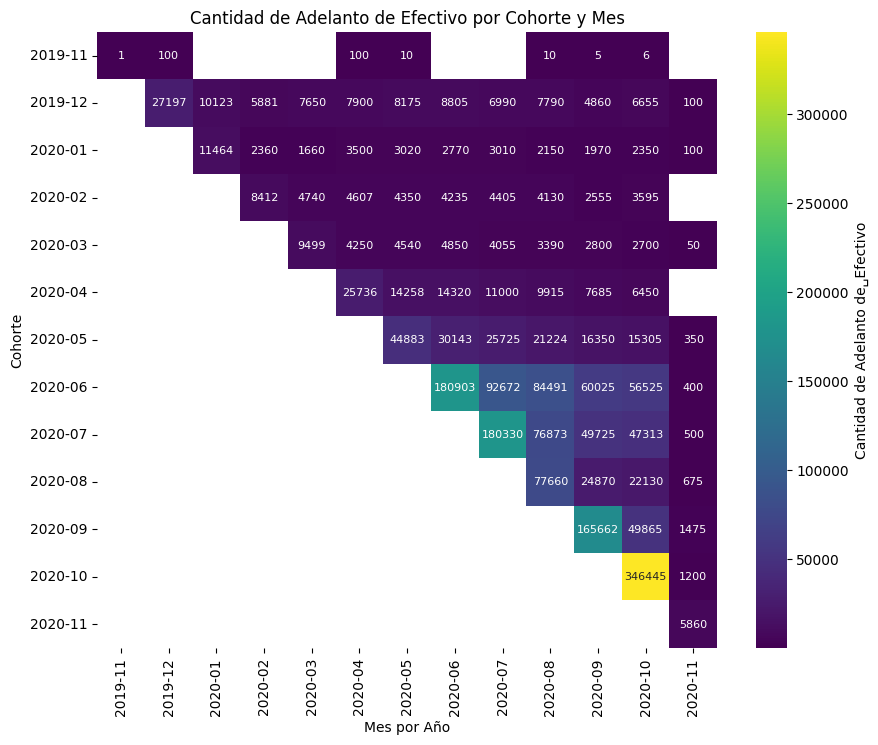

In [16]:
# Graficar la cantidad de adelanto de efectivo por cohorte y mes
plt.figure(figsize=(10, 8))
plt.title('Cantidad de Adelanto de Efectivo por Cohorte y Mes')
sns.heatmap(data=cohort_revenue, annot=True, fmt='.0f', cmap='viridis',annot_kws={"size": 8}, cbar_kws={'label': 'Cantidad de Adelanto de␣Efectivo'})
plt.xlabel('Mes por Año')
plt.ylabel('Cohorte')
plt.show()


In [17]:
# Crear DataFrame de cohortes para el mes de '2020-03'
cohort_amount_2020_03 = cr[cr['Cohorte'] == '2020-03'].groupby('user_id')['amount'].sum().reset_index()
cohort_amount_2020_03


,user_id,amount
0,161.0,400.0
1,400.0,800.0
2,447.0,100.0
3,448.0,80.0
4,475.0,100.0
...,...,...
81,13975.0,650.0
82,14798.0,650.0
83,16345.0,400.0
84,21228.0,200.0


In [18]:
# Ordenar por el monto total para encontrar los 10 usuarios principales
sort_cohort_amount_2020_03 = cohort_amount_2020_03.sort_values(by='amount',ascending=False)
top_10_users = sort_cohort_amount_2020_03.head(10)
top_10_users

,user_id,amount
36,3377.0,1305.0
52,4297.0,1200.0
45,3617.0,1000.0
50,3948.0,950.0
20,2548.0,900.0
43,3557.0,900.0
9,680.0,850.0
77,4715.0,800.0
1,400.0,800.0
6,496.0,750.0


In [19]:
# Filtrar para incluir solo los 10 usuarios seleccionados
amount_2020_03 = cr[cr['Cohorte'] == '2020-03'].groupby(['user_id','Mes'])['amount'].sum().reset_index()
cohort_amount_2020_03_top10 = amount_2020_03[amount_2020_03['user_id'].isin(top_10_users['user_id'])]
cohort_amount_2020_03_top10 = cohort_amount_2020_03_top10.pivot(index='user_id', columns='Mes', values='amount')
cohort_amount_2020_03_top10


Mes,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11
user_id,,,,,,,,,
400.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,NaN
496.0,150.0,NaN,100.0,100.0,100.0,100.0,100.0,100.0,NaN
680.0,200.0,100.0,100.0,100.0,100.0,100.0,100.0,50.0,NaN
2548.0,100.0,100.0,100.0,100.0,100.0,200.0,NaN,200.0,NaN
3377.0,300.0,150.0,270.0,200.0,185.0,100.0,50.0,NaN,50.0
3557.0,200.0,200.0,NaN,200.0,200.0,100.0,NaN,NaN,NaN
3617.0,200.0,NaN,200.0,100.0,200.0,100.0,100.0,100.0,NaN
3948.0,200.0,200.0,200.0,100.0,NaN,100.0,NaN,150.0,NaN
4297.0,200.0,200.0,200.0,200.0,200.0,100.0,100.0,NaN,NaN


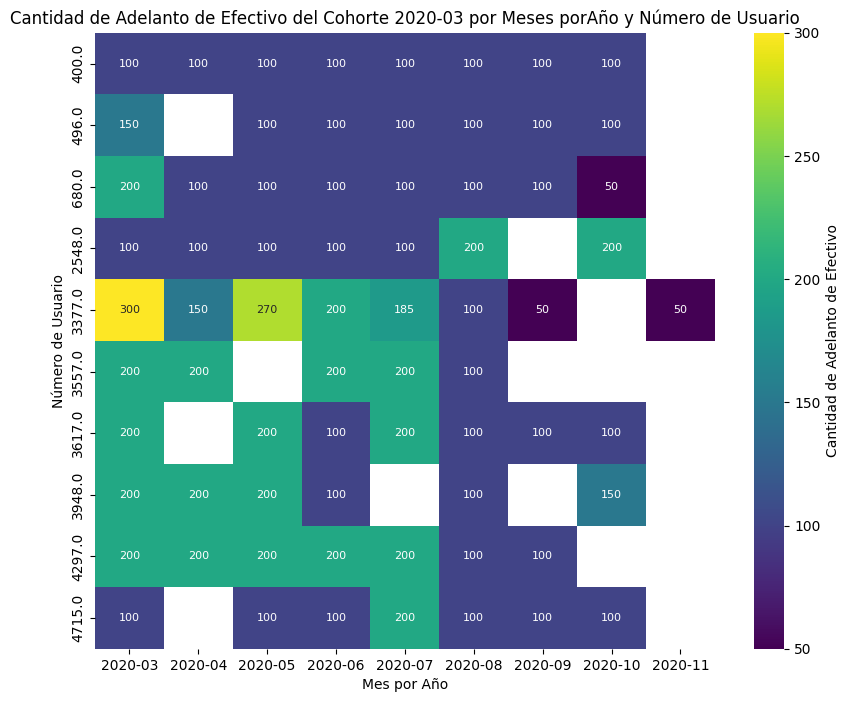

In [20]:
# Graficar la cantidad de adelanto de efectivo de un cohorte por meses y número␣de usuarios
plt.figure(figsize=(10, 8))
plt.title('Cantidad de Adelanto de Efectivo del Cohorte 2020-03 por Meses porAño y Número de Usuario')
sns.heatmap(data=cohort_amount_2020_03_top10, annot=True, fmt='.0f',cmap='viridis', annot_kws={"size": 8}, cbar_kws={'label': 'Cantidad de Adelanto de Efectivo'})
plt.xlabel('Mes por Año')
plt.ylabel('Número de Usuario')
plt.show()

In [21]:
# Filtrar para calcular la cantidad de adelanto de efectivo por cohorte y semana
cohort_weekly_amount = cr[cr['Cohorte'] == '2020-03'].groupby(['user_id','Semana_Mes'])['amount'].sum().reset_index()
cohort_weekly_amount

,user_id,Semana_Mes,amount
0,161.0,09_March_2020,100.0
1,161.0,14_April_2020,100.0
2,161.0,19_May_2020,100.0
3,161.0,23_June_2020,100.0
4,400.0,10_March_2020,100.0
...,...,...,...
362,16345.0,31_August_2020,100.0
363,16345.0,36_September_2020,100.0
364,21228.0,13_March_2020,100.0
365,21228.0,32_August_2020,100.0


In [22]:
# Filtrar para incluir solo los 10 usuarios seleccionados
cohort_weekly_amount_top10 =cohort_weekly_amount[cohort_weekly_amount['user_id'].isin(top_10_users['user_id'])]
cohort_weekly_amount_top10 = cohort_weekly_amount_top10.pivot(index='user_id',columns='Semana_Mes', values='amount')
cohort_weekly_amount_top10

Semana_Mes,09_March_2020,10_March_2020,11_March_2020,12_March_2020,13_April_2020,14_April_2020,15_April_2020,16_April_2020,18_May_2020,19_May_2020,...,33_August_2020,34_August_2020,35_August_2020,35_September_2020,36_September_2020,37_September_2020,40_October_2020,41_October_2020,43_October_2020,44_November_2020
user_id,,,,,,,,,,,,,,,,,,,,,
400.0,NaN,100.0,NaN,NaN,NaN,100.0,NaN,NaN,100.0,NaN,...,NaN,NaN,NaN,NaN,NaN,100.0,100.0,NaN,NaN,NaN
496.0,NaN,100.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,100.0,NaN,NaN,100.0,NaN,NaN
680.0,100.0,NaN,100.0,NaN,NaN,100.0,NaN,NaN,NaN,100.0,...,NaN,NaN,NaN,100.0,NaN,NaN,50.0,NaN,NaN,NaN
2548.0,100.0,NaN,NaN,NaN,NaN,NaN,100.0,NaN,100.0,NaN,...,NaN,NaN,100.0,NaN,NaN,NaN,100.0,NaN,100.0,NaN
3377.0,NaN,100.0,100.0,100.0,50.0,NaN,NaN,100.0,100.0,50.0,...,NaN,NaN,NaN,50.0,NaN,NaN,NaN,NaN,NaN,50.0
3557.0,NaN,200.0,NaN,NaN,NaN,200.0,NaN,NaN,NaN,NaN,...,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3617.0,200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,100.0,NaN,NaN,NaN,100.0,NaN,NaN
3948.0,NaN,NaN,100.0,100.0,100.0,NaN,NaN,100.0,NaN,100.0,...,NaN,100.0,NaN,NaN,NaN,NaN,50.0,NaN,100.0,NaN
4297.0,NaN,NaN,200.0,NaN,200.0,NaN,NaN,NaN,NaN,200.0,...,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN


In [23]:
# Seleccionar las primeras 10 semanas
cohort_weekly_amount_top10 = cohort_weekly_amount_top10.loc[:,cohort_weekly_amount_top10.columns[:10]]
cohort_weekly_amount_top10

Semana_Mes,09_March_2020,10_March_2020,11_March_2020,12_March_2020,13_April_2020,14_April_2020,15_April_2020,16_April_2020,18_May_2020,19_May_2020
user_id,,,,,,,,,,
400.0,NaN,100.0,NaN,NaN,NaN,100.0,NaN,NaN,100.0,NaN
496.0,NaN,100.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
680.0,100.0,NaN,100.0,NaN,NaN,100.0,NaN,NaN,NaN,100.0
2548.0,100.0,NaN,NaN,NaN,NaN,NaN,100.0,NaN,100.0,NaN
3377.0,NaN,100.0,100.0,100.0,50.0,NaN,NaN,100.0,100.0,50.0
3557.0,NaN,200.0,NaN,NaN,NaN,200.0,NaN,NaN,NaN,NaN
3617.0,200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3948.0,NaN,NaN,100.0,100.0,100.0,NaN,NaN,100.0,NaN,100.0
4297.0,NaN,NaN,200.0,NaN,200.0,NaN,NaN,NaN,NaN,200.0


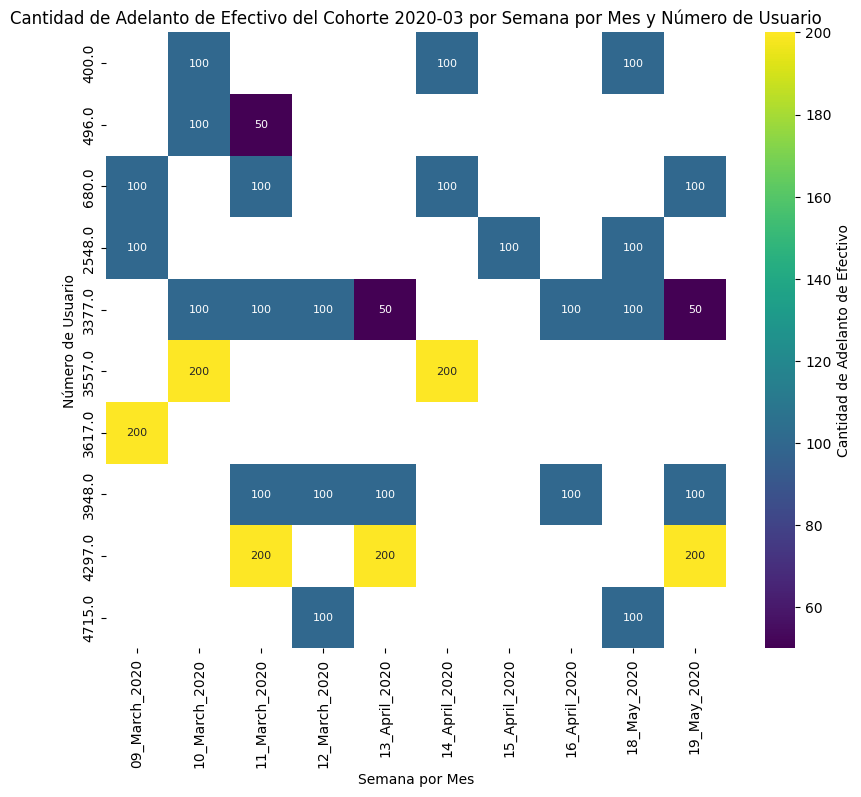

In [24]:
# Graficar la cantidad de adelanto de efectivo de los 10 principales usuarios␣por semana
plt.figure(figsize=(10, 8))
plt.title('Cantidad de Adelanto de Efectivo del Cohorte 2020-03 por Semana por Mes y Número de Usuario')
sns.heatmap(data=cohort_weekly_amount_top10, annot=True, fmt='.0f',cmap='viridis', annot_kws={"size": 8}, cbar_kws={'label': 'Cantidad de Adelanto de Efectivo'})
plt.xlabel('Semana por Mes')
plt.ylabel('Número de Usuario')
plt.show()

In [25]:
# Filtrar para calcular la cantidad de adelanto de efectivo por cohorte y día␣de la semana
cohort_daily_amount = cr[ (cr['Cohorte'] == '2020-03') & (cr['Semana_Mes'] =='10_March_2020') ].groupby(['user_id', 'Dia_Semana'])['amount'].sum().reset_index()
cohort_daily_amount

,user_id,Dia_Semana,amount
0,400.0,Monday_10_March_2020,100.0
1,475.0,Monday_10_March_2020,100.0
2,479.0,Tuesday_10_March_2020,100.0
3,496.0,Wednesday_10_March_2020,100.0
4,575.0,Tuesday_10_March_2020,100.0
5,876.0,Thursday_10_March_2020,100.0
6,1101.0,Friday_10_March_2020,100.0
7,1280.0,Monday_10_March_2020,100.0
8,2197.0,Monday_10_March_2020,100.0
9,2976.0,Wednesday_10_March_2020,50.0


In [26]:
# Filtrar para incluir solo los 10 usuarios seleccionados
cohort_daily_amount_top10 = cohort_daily_amount[cohort_daily_amount['user_id'].isin(top_10_users['user_id'])]
cohort_daily_amount_top10 = cohort_daily_amount_top10.pivot(index='user_id',columns='Dia_Semana', values='amount')
cohort_daily_amount_top10

Dia_Semana,Monday_10_March_2020,Wednesday_10_March_2020
user_id,,
400.0,100.0,NaN
496.0,NaN,100.0
3377.0,100.0,NaN
3557.0,NaN,200.0


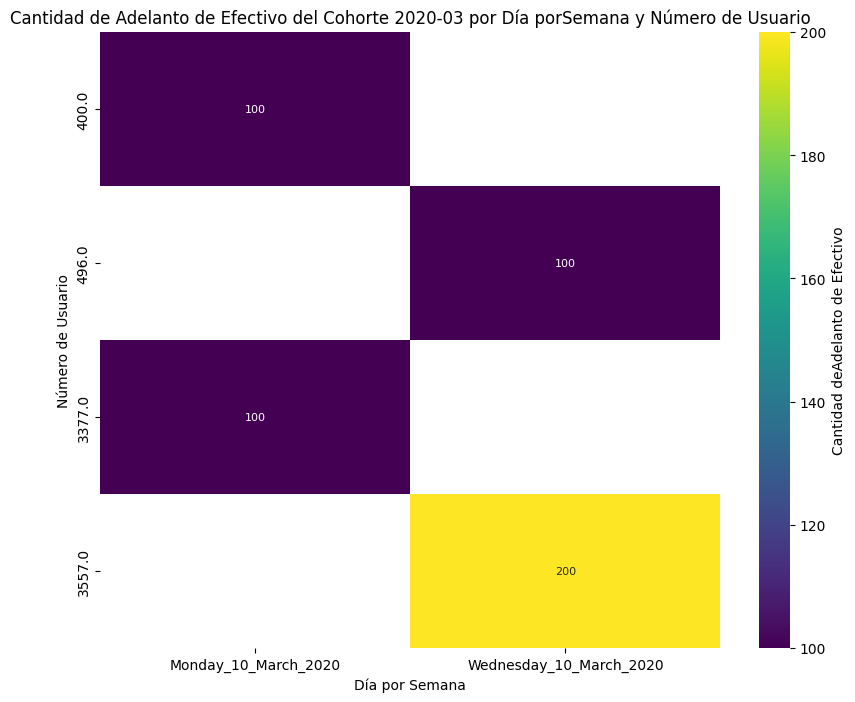

In [27]:
# Graficar la cantidad de adelanto de efectivo de los 10 principales usuariospor día de la semana
plt.figure(figsize=(10, 8))
plt.title('Cantidad de Adelanto de Efectivo del Cohorte 2020-03 por Día porSemana y Número de Usuario')
sns.heatmap(data=cohort_daily_amount_top10, annot=True, fmt='.0f',cmap='viridis', annot_kws={"size": 8}, cbar_kws={'label': 'Cantidad deAdelanto de Efectivo'})
plt.xlabel('Día por Semana')
plt.ylabel('Número de Usuario')
plt.show()

In [28]:
# Filtrar para calcular la cantidad de adelanto de efectivo por cohorte y hora
cohort_hourly_amount = cr[(cr['Cohorte'] == '2020-03') & (cr['Semana_Mes'] =='10_March_2020') & (cr['Dia_Semana'] == 'Monday_10_March_2020')].groupby(['user_id', 'Hora_Dia'])['amount'].sum().reset_index()
cohort_hourly_amount

,user_id,Hora_Dia,amount
0,400.0,7_Monday_10_March_2020,100.0
1,475.0,9_Monday_10_March_2020,100.0
2,1280.0,19_Monday_10_March_2020,100.0
3,2197.0,15_Monday_10_March_2020,100.0
4,3377.0,13_Monday_10_March_2020,100.0
5,4474.0,10_Monday_10_March_2020,100.0
6,10430.0,15_Monday_10_March_2020,100.0


In [29]:
# Filtrar para incluir solo los 10 usuarios seleccionados
cohort_hourly_amount_top10 =cohort_hourly_amount[cohort_hourly_amount['user_id'].isin(top_10_users['user_id'])]
cohort_hourly_amount_top10 = cohort_hourly_amount_top10.pivot(index='user_id',columns='Hora_Dia', values='amount')
cohort_hourly_amount_top10

Hora_Dia,13_Monday_10_March_2020,7_Monday_10_March_2020
user_id,,
400.0,NaN,100.0
3377.0,100.0,NaN


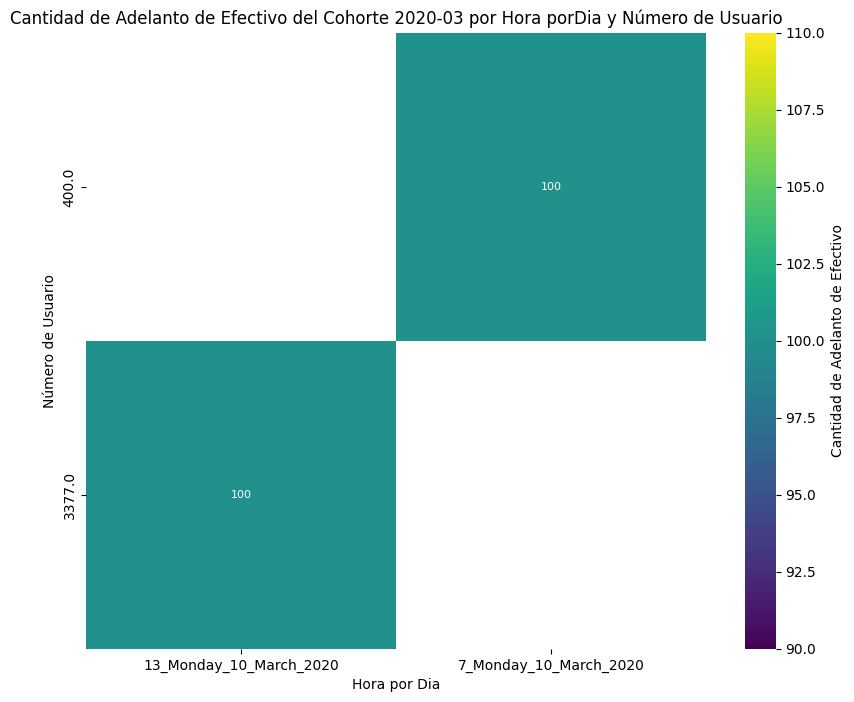

In [30]:
 # Graficar la cantidad de adelanto de efectivo de los 10 principales usuariospor hora
plt.figure(figsize=(10, 8))
plt.title('Cantidad de Adelanto de Efectivo del Cohorte 2020-03 por Hora porDia y Número de Usuario')
sns.heatmap(data=cohort_hourly_amount_top10, annot=True, fmt='.0f',cmap='viridis', annot_kws={"size": 8}, cbar_kws={'label': 'Cantidad de Adelanto de Efectivo'})
plt.xlabel('Hora por Dia')
plt.ylabel('Número de Usuario')
plt.show()


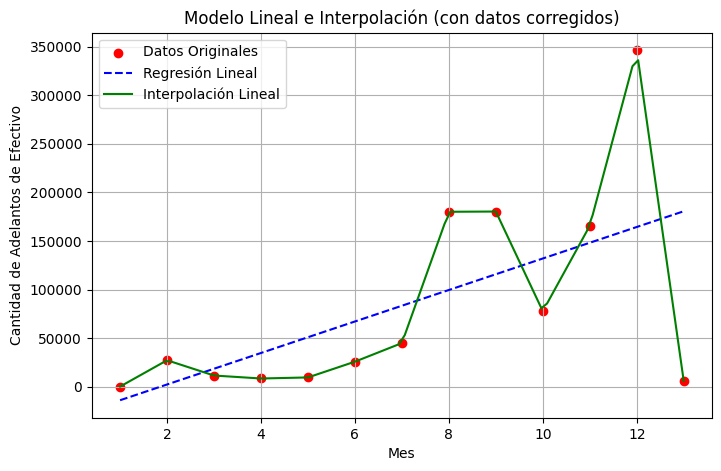

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression

# Datos corregidos (incluyendo el último mes con 346445 y 5860)
x_meses = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])  # Ahora incluye el mes 13
y_valores = np.array([100, 27197, 11464, 8412, 9499, 25736, 44883, 180093, 180330, 77660, 165662, 346445, 5860])  # Incluye valores corregidos

# Ajustar modelo lineal
modelo_lineal = LinearRegression()
x_meses_reshape = x_meses.reshape(-1, 1)  # Cambiar forma para el modelo
modelo_lineal.fit(x_meses_reshape, y_valores)

# Predecir valores con el modelo
x_pred = np.linspace(1, 13, 100).reshape(-1, 1)  # Ahora incluye el mes 13
y_pred = modelo_lineal.predict(x_pred)

# Interpolación lineal
interp_linear = interp1d(x_meses, y_valores, kind='linear')
x_interp = np.linspace(1, 13, 100)  # Ahora incluye el mes 13
y_interp = interp_linear(x_interp)

# Graficar resultados
plt.figure(figsize=(8, 5))
plt.scatter(x_meses, y_valores, color='red', label='Datos Originales')  # Datos corregidos
plt.plot(x_pred, y_pred, label='Regresión Lineal', linestyle='dashed', color='blue')
plt.plot(x_interp, y_interp, label='Interpolación Lineal', linestyle='solid', color='green')
plt.xlabel('Mes')
plt.ylabel('Cantidad de Adelantos de Efectivo')
plt.title('Modelo Lineal e Interpolación (con datos corregidos)')
plt.legend()
plt.grid()
plt.show()

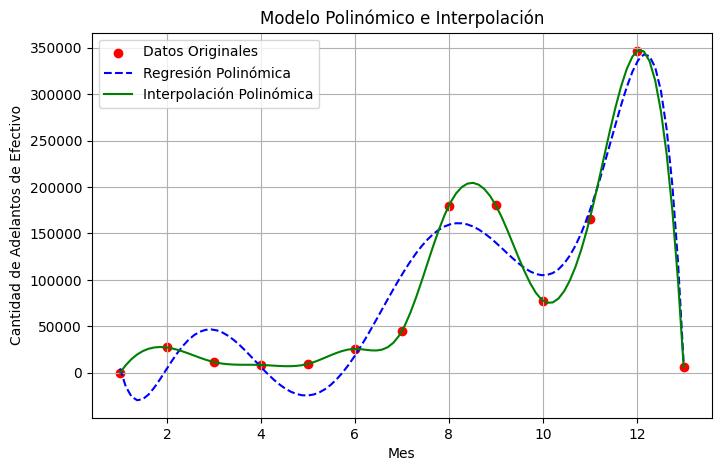

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Datos corregidos
x_meses = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])  # Se agregó el mes 13
y_valores = np.array([100, 27197, 11464, 8412, 9499, 25736, 44883, 180093, 180330, 77660, 165662, 346445, 5860])

# Ajuste polinómico de grado 3
coeficientes = np.polyfit(x_meses, y_valores, 7)
polinomio = np.poly1d(coeficientes)

# Predicción con el modelo polinómico
x_pred = np.linspace(1, 13, 100)  # Se ajustó el rango a 13
y_pred = polinomio(x_pred)

# Interpolación polinómica
interp_polinomica = interp1d(x_meses, y_valores, kind='cubic')
y_interp = interp_polinomica(x_pred)

# Graficar resultados
plt.figure(figsize=(8, 5))
plt.scatter(x_meses, y_valores, color='red', label='Datos Originales')
plt.plot(x_pred, y_pred, label='Regresión Polinómica', linestyle='dashed', color='blue')
plt.plot(x_pred, y_interp, label='Interpolación Polinómica', linestyle='solid', color='green')
plt.xlabel('Mes')
plt.ylabel('Cantidad de Adelantos de Efectivo')
plt.title('Modelo Polinómico e Interpolación')
plt.legend()
plt.grid()
plt.show()

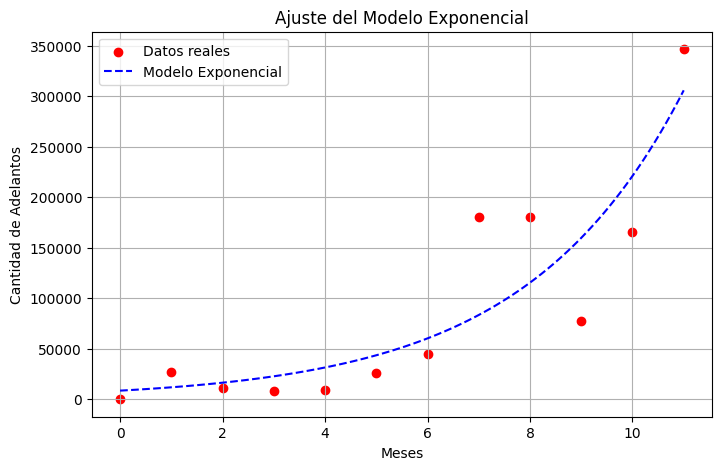

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

# Función exponencial para el ajuste
def exp_model(x, a, b):
    return a * np.exp(b * x)

# Datos (meses y valores de los cuadros rojos)
meses = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])  # Representación numérica de los meses
valores = np.array([100, 27197, 11464, 8412, 9499, 25736, 44883, 180903, 180330, 77660, 165662, 346445])  # Valores totales por mes

# Ajuste del modelo exponencial
params, _ = curve_fit(exp_model, meses, valores, p0=(1, 0.1))  # p0 es una estimación inicial
a, b = params

# Predicción con el modelo
meses_pred = np.linspace(0, 11, 100)  # Más puntos para suavizar la curva
valores_pred = exp_model(meses_pred, a, b)

# Visualización del modelo exponencial
plt.figure(figsize=(8, 5))
plt.scatter(meses, valores, color='red', label="Datos reales")  # Puntos originales
plt.plot(meses_pred, valores_pred, 'b--', label="Modelo Exponencial")  # Línea de ajuste
plt.xlabel("Meses")
plt.ylabel("Cantidad de Adelantos")
plt.legend()
plt.title("Ajuste del Modelo Exponencial")
plt.grid()
plt.show()


Métricas de Evaluación de Modelos:
📊 Modelo Lineal: MSE = 6465834747.29, R² = 0.3628
📊 Modelo Polinómico: MSE = 4942176140.57, R² = 0.5130
📊 Modelo Exponencial: MSE = 7108873505.12, R² = 0.2994


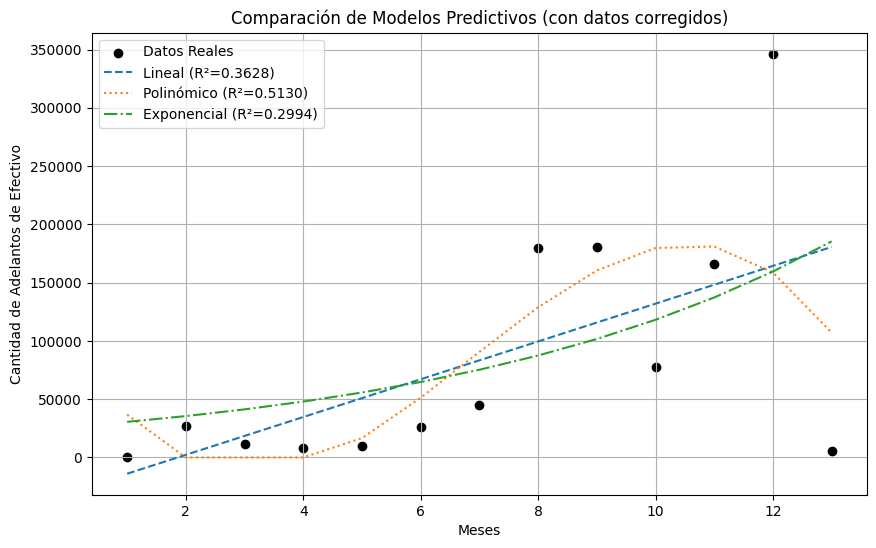

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score
from numpy.polynomial import Polynomial

# Datos corregidos
meses = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])  # Ahora incluye el mes 13
adelantos = np.array([100, 27197, 11464, 8412, 9499, 25736, 44883, 180093, 180330, 77660, 165662, 346445, 5860])  # Datos corregidos

# 1. Modelo Lineal
def modelo_lineal(x, a, b):
    return a * x + b

param_lineal, _ = curve_fit(modelo_lineal, meses, adelantos)
y_pred_lineal = modelo_lineal(meses, *param_lineal)
mse_lineal = mean_squared_error(adelantos, y_pred_lineal)
r2_lineal = r2_score(adelantos, y_pred_lineal)

# 2. Modelo Polinómico (Grado 3)
polinomio = Polynomial.fit(meses, adelantos, 3)  # Grado 3 para evitar sobreajuste
y_pred_polinomico = polinomio(meses)
y_pred_polinomico = np.maximum(0, y_pred_polinomico)  # Aseguramos que no haya valores negativos
mse_polinomico = mean_squared_error(adelantos, y_pred_polinomico)
r2_polinomico = r2_score(adelantos, y_pred_polinomico)

# 3. Modelo Exponencial
def modelo_exponencial(x, a, b):
    return a * np.exp(b * x)

param_exponencial, _ = curve_fit(modelo_exponencial, meses, adelantos, p0=[1, 0.1])
y_pred_exponencial = modelo_exponencial(meses, *param_exponencial)
y_pred_exponencial = np.maximum(0, y_pred_exponencial)  # Aseguramos que no haya valores negativos
mse_exponencial = mean_squared_error(adelantos, y_pred_exponencial)
r2_exponencial = r2_score(adelantos, y_pred_exponencial)

# Mostrar los resultados
print("Métricas de Evaluación de Modelos:")
print(f"📊 Modelo Lineal: MSE = {mse_lineal:.2f}, R² = {r2_lineal:.4f}")
print(f"📊 Modelo Polinómico: MSE = {mse_polinomico:.2f}, R² = {r2_polinomico:.4f}")
print(f"📊 Modelo Exponencial: MSE = {mse_exponencial:.2f}, R² = {r2_exponencial:.4f}")

# Graficamos las predicciones de cada modelo
plt.figure(figsize=(10, 6))
plt.scatter(meses, adelantos, color="black", label="Datos Reales")
plt.plot(meses, y_pred_lineal, label=f"Lineal (R²={r2_lineal:.4f})", linestyle="dashed")
plt.plot(meses, y_pred_polinomico, label=f"Polinómico (R²={r2_polinomico:.4f})", linestyle="dotted")
plt.plot(meses, y_pred_exponencial, label=f"Exponencial (R²={r2_exponencial:.4f})", linestyle="dashdot")
plt.xlabel("Meses")
plt.ylabel("Cantidad de Adelantos de Efectivo")
plt.legend()
plt.title("Comparación de Modelos Predictivos (con datos corregidos)")
plt.grid()
plt.show()


Métricas de Evaluación de Modelos:
📊 Modelo Lineal: MSE = 6465834747.29, R² = 0.3628
📊 Modelo Polinómico: MSE = 6359277197.11, R² = 0.3733
📊 Modelo Exponencial: MSE = 7108873505.12, R² = 0.2994
El mejor modelo es el Modelo Polinómico


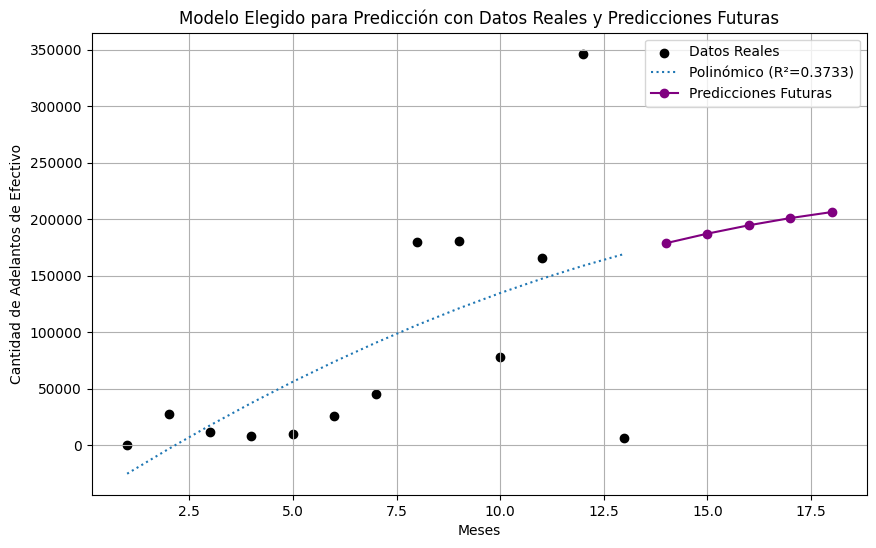

Predicciones para los meses futuros (14-18): [178712.         187155.84615385 194563.37362637 200934.58241758
 206269.47252747]


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score
from numpy.polynomial import Polynomial

# Datos corregidos
meses = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
adelantos = np.array([100, 27197, 11464, 8412, 9499, 25736, 44883, 180093, 180330, 77660, 165662, 346445, 5860])

# 1. Modelo Lineal
def modelo_lineal(x, a, b):
    return a * x + b

param_lineal, _ = curve_fit(modelo_lineal, meses, adelantos)
y_pred_lineal = modelo_lineal(meses, *param_lineal)
mse_lineal = mean_squared_error(adelantos, y_pred_lineal)
r2_lineal = r2_score(adelantos, y_pred_lineal)

# 2. Modelo Polinómico (Grado 2)
polinomio = Polynomial.fit(meses, adelantos, 2)  # Grado 2 en lugar de grado 3 para evitar sobreajuste
y_pred_polinomico = polinomio(meses)
y_pred_polinomico = np.maximum(0, y_pred_polinomico)  # Aseguramos que no haya valores negativos
mse_polinomico = mean_squared_error(adelantos, y_pred_polinomico)
r2_polinomico = r2_score(adelantos, y_pred_polinomico)

# 3. Modelo Exponencial
def modelo_exponencial(x, a, b):
    return a * np.exp(b * x)

param_exponencial, _ = curve_fit(modelo_exponencial, meses, adelantos, p0=[1, 0.1])
y_pred_exponencial = modelo_exponencial(meses, *param_exponencial)
y_pred_exponencial = np.maximum(0, y_pred_exponencial)  # Aseguramos que no haya valores negativos
mse_exponencial = mean_squared_error(adelantos, y_pred_exponencial)
r2_exponencial = r2_score(adelantos, y_pred_exponencial)

# Mostrar los resultados de las métricas
print("Métricas de Evaluación de Modelos:")
print(f"📊 Modelo Lineal: MSE = {mse_lineal:.2f}, R² = {r2_lineal:.4f}")
print(f"📊 Modelo Polinómico: MSE = {mse_polinomico:.2f}, R² = {r2_polinomico:.4f}")
print(f"📊 Modelo Exponencial: MSE = {mse_exponencial:.2f}, R² = {r2_exponencial:.4f}")

# Comparar los valores de MSE y R²
# Seleccionamos el modelo con menor MSE y mayor R²
if mse_lineal == min(mse_lineal, mse_polinomico, mse_exponencial) and r2_lineal == max(r2_lineal, r2_polinomico, r2_exponencial):
    print("El mejor modelo es el Modelo Lineal")
    mejor_modelo = modelo_lineal
    mejor_parametros = param_lineal
    r2_mejor = r2_lineal
elif mse_polinomico == min(mse_lineal, mse_polinomico, mse_exponencial) and r2_polinomico == max(r2_lineal, r2_polinomico, r2_exponencial):
    print("El mejor modelo es el Modelo Polinómico")
    mejor_modelo = polinomio
    mejor_parametros = None  # No tiene parámetros como el modelo lineal
    r2_mejor = r2_polinomico
else:
    print("El mejor modelo es el Modelo Exponencial")
    mejor_modelo = modelo_exponencial
    mejor_parametros = param_exponencial
    r2_mejor = r2_exponencial

# Visualización del modelo elegido
plt.figure(figsize=(10, 6))
plt.scatter(meses, adelantos, color="black", label="Datos Reales")

# Predicción del mejor modelo
if mejor_modelo == modelo_lineal:
    y_pred_mejor = mejor_modelo(meses, *mejor_parametros)
    plt.plot(meses, y_pred_mejor, label=f"Lineal (R²={r2_mejor:.4f})", linestyle="dashed")
elif mejor_modelo == polinomio:
    y_pred_mejor = mejor_modelo(meses)
    plt.plot(meses, y_pred_mejor, label=f"Polinómico (R²={r2_mejor:.4f})", linestyle="dotted")
else:
    y_pred_mejor = mejor_modelo(meses, *mejor_parametros)
    plt.plot(meses, y_pred_mejor, label=f"Exponencial (R²={r2_mejor:.4f})", linestyle="dashdot")

# Predicción para meses futuros (ejemplo de meses 14-18)
meses_futuros = np.array([14, 15, 16, 17, 18])  # Meses futuros para predicción
if mejor_modelo == modelo_lineal:
    predicciones_futuras = mejor_modelo(meses_futuros, *mejor_parametros)
elif mejor_modelo == polinomio:
    predicciones_futuras = mejor_modelo(meses_futuros)
else:
    predicciones_futuras = mejor_modelo(meses_futuros, *mejor_parametros)

# Asegurar que las predicciones futuras no sean negativas
predicciones_futuras = np.maximum(0, predicciones_futuras)

# Graficar las predicciones futuras
plt.plot(meses_futuros, predicciones_futuras, label="Predicciones Futuras", color="purple", linestyle="solid", marker="o")

# Ajustar la visualización
plt.xlabel("Meses")
plt.ylabel("Cantidad de Adelantos de Efectivo")
plt.legend()
plt.title("Modelo Elegido para Predicción con Datos Reales y Predicciones Futuras")
plt.grid()
plt.show()

# Mostrar las predicciones para los meses futuros
print(f"Predicciones para los meses futuros (14-18): {predicciones_futuras}")
